# Fine-Tuning Phi-2 for Abstractive Text Summarization

## Task 3: Instruction-Based Fine-Tuning of a Decoder-Only Language Model

Notebook ini menunjukkan proses fine-tuning **Microsoft Phi-2**, sebuah model bahasa **decoder-only berbasis causal language modeling**, untuk tugas **abstractive text summarization** menggunakan dataset **XSum**.

### Deskripsi Singkat
- **Model**: microsoft/phi-2 (2.7 miliar parameter, arsitektur decoder-only)
- **Dataset**: EdinburghNLP/xsum (dataset extreme summarization)
- **Tugas**: Menghasilkan ringkasan singkat berbentuk satu kalimat secara abstractive
- **Pendekatan**: Instruction-based prompting yang diformulasikan sebagai causal language modeling


## Installation & Library Import

Pada tahap awal, dilakukan instalasi seluruh library yang dibutuhkan untuk proses **fine-tuning model bahasa berbasis Transformer**. Library yang digunakan mencakup pemodelan deep learning, pengelolaan dataset, serta optimasi training agar dapat berjalan efisien pada GPU dengan resource terbatas.

Setelah proses instalasi selesai, dilakukan import berbagai modul pendukung yang akan digunakan sepanjang eksperimen, antara lain:

- **PyTorch (`torch`)**  
  Digunakan sebagai backend utama untuk komputasi dan training model deep learning.

- **NumPy (`numpy`)** dan **Pandas (`pandas`)**  
  Digunakan untuk kebutuhan manipulasi data numerik dan tabular.

- **Hugging Face Datasets**  
  Digunakan untuk memuat, mengelola, dan memproses dataset secara efisien dalam format yang kompatibel dengan pipeline training.

- **Hugging Face Transformers**  
  Menyediakan komponen utama seperti tokenizer, model language model (Causal LM), serta konfigurasi training dan trainer.

- **PEFT (Parameter-Efficient Fine-Tuning)**  
  Digunakan untuk menerapkan metode **LoRA (Low-Rank Adaptation)**, sehingga proses fine-tuning dapat dilakukan dengan konsumsi memori yang lebih rendah dan cocok untuk GPU kelas menengah seperti T4.

Tahapan ini bertujuan untuk memastikan seluruh dependensi dan modul telah siap sebelum masuk ke proses konfigurasi model dan pelatihan.


In [1]:
# Install required packages (uncomment if needed)
!pip install transformers datasets evaluate rouge_score accelerate peft bitsandbytes -q

import warnings
warnings.filterwarnings('ignore')

# Import core libraries
import torch
import numpy as np
import pandas as pd
from datasets import Dataset
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    TrainingArguments,
    Trainer,
    DataCollatorForLanguageModeling,
    BitsAndBytesConfig
)
from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training, TaskType
import evaluate

# Fix for bitsandbytes availability detection on Windows
# The transformers library caches the bitsandbytes availability check at import time
# If bitsandbytes was installed after transformers was imported, we need to patch it
import importlib
import transformers.utils.import_utils as import_utils
from transformers.utils import is_bitsandbytes_available

import_utils._bitsandbytes_available = True
is_bitsandbytes_available.cache_clear()

# Reload bitsandbytes integration module to load conditional imports
import transformers.integrations.bitsandbytes
importlib.reload(transformers.integrations.bitsandbytes)

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.1/59.1 MB 17.7 MB/s eta 0:00:00


<module 'transformers.integrations.bitsandbytes' from '/usr/local/lib/python3.12/dist-packages/transformers/integrations/bitsandbytes.py'>

## Device & Hardware Check

Pada tahap ini dilakukan pengecekan ketersediaan **GPU (CUDA)** pada environment yang digunakan.  
Jika GPU terdeteksi, maka proses training akan dijalankan menggunakan **CUDA** untuk mempercepat komputasi.  
Apabila GPU tidak tersedia, sistem secara otomatis akan menggunakan **CPU** sebagai alternatif.

Selain itu, apabila GPU aktif, informasi mengenai **nama GPU** yang digunakan akan ditampilkan.  
Langkah ini bertujuan untuk memastikan bahwa eksperimen berjalan pada perangkat keras yang sesuai, khususnya saat menggunakan GPU seperti **NVIDIA T4** pada Google Colab.


In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device aktif: {device}")

if device == "cuda":
    print(torch.cuda.get_device_name(0))

Device aktif: cuda
Tesla T4


## Dataset Loading (XSum)

Pada tahap ini, dataset **XSum** dimuat secara langsung dari **Hugging Face Hub** dalam format **Parquet**. Pendekatan ini dipilih karena format Parquet lebih efisien dalam hal pembacaan data dan penggunaan memori dibandingkan format teks biasa.

Dataset XSum terdiri dari tiga subset utama, yaitu:
- **Train**, digunakan untuk proses pelatihan model
- **Validation**, digunakan untuk evaluasi model selama proses training
- **Test**, digunakan untuk pengujian akhir model

Masing-masing subset dimuat ke dalam **Pandas DataFrame** agar memudahkan proses eksplorasi data, pengecekan struktur kolom, serta integrasi dengan tahapan preprocessing selanjutnya.

Setelah seluruh subset berhasil dimuat, ditampilkan jumlah sampel pada setiap subset beserta daftar kolom yang tersedia. Langkah ini bertujuan untuk memastikan dataset telah dimuat dengan benar dan siap digunakan pada tahap berikutnya.


In [3]:
# Load the XSum dataset directly from Hugging Face Hub parquet files

print("Loading XSum dataset from Hugging Face Hub...")

base_url = "https://huggingface.co/datasets/EdinburghNLP/xsum/resolve/refs%2Fconvert%2Fparquet/default"
train_url = f"{base_url}/train/0000.parquet"
val_url = f"{base_url}/validation/0000.parquet"
test_url = f"{base_url}/test/0000.parquet"

print("Loading train split...")
train_df = pd.read_parquet(train_url)
print("Loading validation split...")
val_df = pd.read_parquet(val_url)
print("Loading test split...")
test_df = pd.read_parquet(test_url)

print(f"\nDataset loaded successfully!")
print(f"Train samples: {len(train_df):,}")
print(f"Validation samples: {len(val_df):,}")
print(f"Test samples: {len(test_df):,}")
print(f"\nColumns: {list(train_df.columns)}")

Loading XSum dataset from Hugging Face Hub...
Loading train split...
Loading validation split...
Loading test split...

Dataset loaded successfully!
Train samples: 204,045
Validation samples: 11,332
Test samples: 11,334

Columns: ['document', 'summary', 'id']


## Exploratory Data Analysis (EDA)

Pada tahap ini dilakukan **Exploratory Data Analysis (EDA)** untuk memahami karakteristik dataset sebelum digunakan dalam proses pelatihan model. Analisis difokuskan pada distribusi panjang teks pada dokumen berita dan ringkasannya.

Sebanyak sebagian data dari subset training diambil sebagai sampel untuk keperluan visualisasi. Panjang teks dihitung berdasarkan jumlah kata pada setiap dokumen dan ringkasan.

Statistik deskriptif ditampilkan untuk memberikan gambaran umum mengenai nilai minimum, maksimum, rata-rata, dan sebaran panjang teks. Informasi ini penting untuk menentukan batas maksimum panjang input dan output yang sesuai pada tahap tokenisasi.

Selain itu, dilakukan visualisasi distribusi panjang kata menggunakan histogram. Visualisasi ini membantu dalam mengidentifikasi pola distribusi data serta potensi outlier yang dapat mempengaruhi performa model jika tidak ditangani dengan tepat.


Statistik Deskriptif Panjang Teks:
           doc_len      sum_len
count  2500.000000  2500.000000
mean    378.626000    21.173600
std     289.578702     5.276685
min      11.000000     1.000000
25%     180.750000    18.000000
50%     301.000000    21.000000
75%     500.000000    24.000000
max    3009.000000    55.000000


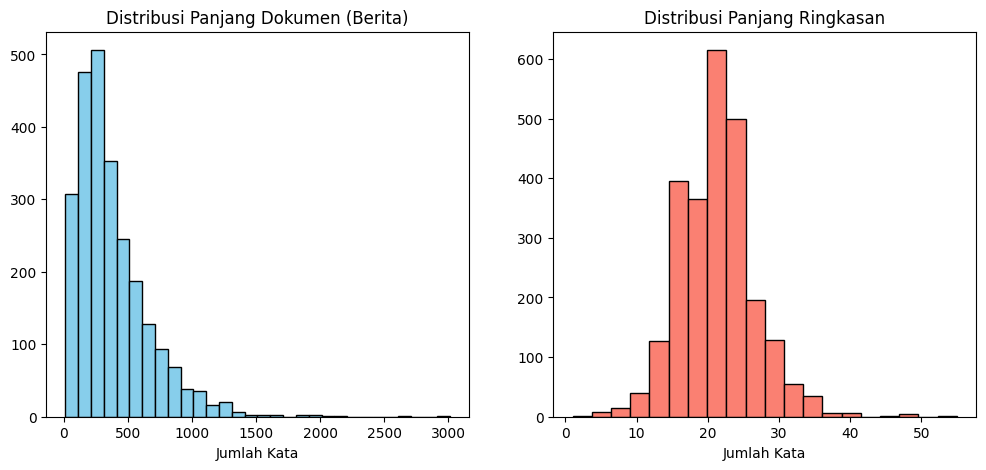

In [4]:
import matplotlib.pyplot as plt

# Konversi sampel dataset ke Pandas untuk visualisasi
df_eda = train_df.head(2500).copy() #

# Hitung jumlah kata
df_eda['doc_len'] = df_eda['document'].apply(lambda x: len(x.split()))
df_eda['sum_len'] = df_eda['summary'].apply(lambda x: len(x.split()))

print("Statistik Deskriptif Panjang Teks:")
print(df_eda[['doc_len', 'sum_len']].describe())

# Visualisasi Distribusi Panjang Kata
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.hist(df_eda['doc_len'], bins=30, color='skyblue', edgecolor='black')
plt.title('Distribusi Panjang Dokumen (Berita)')
plt.xlabel('Jumlah Kata')

plt.subplot(1, 2, 2)
plt.hist(df_eda['sum_len'], bins=20, color='salmon', edgecolor='black')
plt.title('Distribusi Panjang Ringkasan')
plt.xlabel('Jumlah Kata')
plt.show()

## Dataset Subsampling and Conversion

Pada tahap ini dilakukan proses **pembatasan jumlah data (subsampling)** pada dataset training dan validation. Penyesuaian jumlah sampel dilakukan untuk menyeimbangkan kebutuhan komputasi dengan keterbatasan memori GPU serta waktu pelatihan yang tersedia.

Sebelum subset dipilih, data diacak menggunakan **random seed tetap** untuk menjaga konsistensi dan memastikan hasil eksperimen dapat direproduksi. Pendekatan ini penting agar pemilihan data tidak berubah ketika eksperimen dijalankan ulang.

Subset dataset yang telah ditentukan kemudian dikonversi ke dalam format **Hugging Face Dataset**. Format ini diperlukan agar dataset dapat digunakan secara langsung oleh pipeline training berbasis `Trainer`.

Sebagai tahap verifikasi, ditampilkan jumlah sampel pada dataset training dan validation serta struktur fitur dataset untuk memastikan data telah siap digunakan pada tahap preprocessing dan pelatihan model.


In [5]:
# Adjust these numbers based on your GPU memory and time constraints
TRAIN_SIZE = 1000
VAL_SIZE = 100

# Shuffle and select subset with fixed seed for reproducibility
train_subset_df = train_df.sample(n=TRAIN_SIZE, random_state=42).reset_index(drop=True)
val_subset_df = val_df.sample(n=VAL_SIZE, random_state=42).reset_index(drop=True)

# Convert to Hugging Face Dataset format for compatibility with Trainer
train_dataset = Dataset.from_pandas(train_subset_df)
val_dataset = Dataset.from_pandas(val_subset_df)

print(f"Training subset: {len(train_dataset)} samples")
print(f"Validation subset: {len(val_dataset)} samples")
print(f"\nDataset features: {train_dataset.features}")

Training subset: 1000 samples
Validation subset: 100 samples

Dataset features: {'document': Value('string'), 'summary': Value('string'), 'id': Value('string')}


## Model and Tokenizer Configuration

Pada tahap ini dilakukan konfigurasi model dasar yang akan digunakan, yaitu **Phi-2**, beserta pengaturan tokenizer yang sesuai dengan arsitektur model.

Untuk mengoptimalkan penggunaan memori GPU, diterapkan **4-bit quantization** menggunakan `BitsAndBytesConfig`. Teknik ini memungkinkan pemuatan model dengan konsumsi memori yang jauh lebih rendah tanpa mengorbankan performa secara signifikan. Konfigurasi NormalFloat4 (NF4) digunakan karena lebih stabil untuk fine-tuning model bahasa besar, sementara proses komputasi tetap dilakukan dalam format FP16 untuk menjaga kecepatan eksekusi.

Selanjutnya, tokenizer dimuat dari model yang sama agar konsisten dengan vocabulary dan tokenization scheme bawaan Phi-2. Karena Phi-2 merupakan **decoder-only model**, pengaturan `padding_side="left"` diperlukan agar padding tidak mengganggu proses autoregressive generation.

Phi-2 tidak menyediakan pad token secara default, sehingga pad token diset secara eksplisit menggunakan end-of-sequence (EOS) token. Langkah ini penting agar proses batching dan padding berjalan dengan benar selama training.

Sebagai verifikasi, ditampilkan nama model serta ukuran vocabulary untuk memastikan tokenizer berhasil dimuat dan dikonfigurasi dengan benar.


In [6]:
# Model configuration
MODEL_NAME = "microsoft/phi-2"

# Configure 4-bit quantization for memory efficiency
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,                    # Enable 4-bit quantization
    bnb_4bit_quant_type="nf4",            # Use NormalFloat4 quantization
    bnb_4bit_compute_dtype=torch.float16, # Compute in fp16 for speed
    bnb_4bit_use_double_quant=True        # Nested quantization for extra memory savings
)

# Load the tokenizer
tokenizer = AutoTokenizer.from_pretrained(
    MODEL_NAME,
    trust_remote_code=True,
    padding_side="left"  # Important for decoder-only models
)

# Set pad token (Phi-2 doesn't have one by default)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token
    tokenizer.pad_token_id = tokenizer.eos_token_id

print(f"Tokenizer loaded: {MODEL_NAME}")
print(f"Vocabulary size: {tokenizer.vocab_size:,}")

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

added_tokens.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/99.0 [00:00<?, ?B/s]

Tokenizer loaded: microsoft/phi-2
Vocabulary size: 50,257


## Model Loading and Preparation for QLoRA

Pada tahap ini, model **Phi-2** dimuat dengan menerapkan **quantization 4-bit** sesuai konfigurasi yang telah ditentukan sebelumnya. Pendekatan ini bertujuan untuk menekan penggunaan memori GPU sehingga model dapat dijalankan dan di-fine-tune secara efisien pada lingkungan dengan resource terbatas.

Model dimuat menggunakan pengaturan `device_map="auto"`, yang memungkinkan sistem secara otomatis menempatkan komponen model pada perangkat komputasi yang tersedia. Selain itu, format data FP16 digunakan pada bagian model yang tidak terkuantisasi untuk menjaga keseimbangan antara efisiensi memori dan kecepatan komputasi.

Setelah model berhasil dimuat, dilakukan tahap **persiapan untuk k-bit training**. Langkah ini merupakan prasyarat dalam pendekatan **QLoRA**, yang memastikan parameter model siap menerima update melalui adaptor LoRA tanpa melanggar batasan kuantisasi.

Sebagai verifikasi, ditampilkan informasi jumlah total parameter model serta jumlah parameter yang dapat dilatih. Informasi ini digunakan untuk memastikan bahwa proses fine-tuning hanya melibatkan sebagian kecil parameter, sesuai dengan prinsip parameter-efficient fine-tuning.


In [7]:
# Load the model with quantization
model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    quantization_config=bnb_config,
    device_map="auto",           # Automatically distribute across available GPUs
    trust_remote_code=True,
    torch_dtype=torch.float16    # Use fp16 for non-quantized parts
)

# Prepare model for k-bit training (required for QLoRA)
model = prepare_model_for_kbit_training(model)

# Print model information
print(f"\nModel loaded: {MODEL_NAME}")
print(f"Model parameters: {model.num_parameters():,}")
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Trainable parameters: {trainable_params:,}")

config.json:   0%|          | 0.00/735 [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/564M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]


Model loaded: microsoft/phi-2
Model parameters: 2,779,683,840
Trainable parameters: 0


## LoRA Configuration and Application

Pada tahap ini diterapkan metode **Low-Rank Adaptation (LoRA)** untuk melakukan fine-tuning model secara efisien. LoRA memungkinkan pembaruan parameter dilakukan melalui matriks berdimensi rendah, sehingga hanya sebagian kecil parameter tambahan yang dilatih tanpa perlu memperbarui seluruh parameter model.

Konfigurasi LoRA ditentukan melalui beberapa komponen utama, seperti nilai rank, faktor skala, dan dropout, yang berfungsi untuk mengontrol kapasitas adaptasi serta mencegah overfitting. Selain itu, parameter bias tidak dilibatkan dalam proses pelatihan untuk menjaga efisiensi.

LoRA diaplikasikan pada beberapa lapisan perhatian dan feed-forward network pada model Phi-2. Pemilihan lapisan ini bertujuan untuk memberikan fleksibilitas adaptasi yang cukup terhadap task summarization tanpa meningkatkan beban komputasi secara signifikan.

Setelah LoRA diterapkan, informasi mengenai jumlah parameter yang dapat dilatih ditampilkan. Langkah ini digunakan untuk memastikan bahwa proses fine-tuning hanya melibatkan parameter LoRA, sesuai dengan prinsip parameter-efficient fine-tuning.


In [8]:
# Configure LoRA for efficient fine-tuning
lora_config = LoraConfig(
    r=16,                          # Rank of the update matrices
    lora_alpha=32,                 # Scaling factor (usually 2*r)
    lora_dropout=0.05,             # Dropout for regularization
    bias="none",                   # Don't train bias terms
    task_type=TaskType.CAUSAL_LM,  # Causal language modeling task
    target_modules=[               # Target attention layers in Phi-2
        "q_proj",
        "k_proj",
        "v_proj",
        "dense",
        "fc1",
        "fc2"
    ]
)

# Apply LoRA to the model
model = get_peft_model(model, lora_config)

# Print trainable parameters after LoRA
model.print_trainable_parameters()

trainable params: 23,592,960 || all params: 2,803,276,800 || trainable%: 0.8416


## Instruction-Based Data Preprocessing

Pada tahap ini dilakukan proses **preprocessing data** untuk menyesuaikan dataset dengan skema **instruction-based causal language modeling** yang digunakan pada task text summarization.

Setiap dokumen diubah menjadi sebuah **prompt instruksional** yang berisi perintah untuk menghasilkan ringkasan. Prompt ini kemudian digabungkan dengan ringkasan referensi sehingga membentuk satu urutan teks lengkap yang akan dipelajari oleh model.

Seluruh urutan teks ditokenisasi dengan batas maksimum panjang sekuens yang telah ditentukan. Proses truncation dan padding diterapkan untuk memastikan seluruh input memiliki panjang yang seragam dan kompatibel dengan proses training berbasis batch.

Pada tahap pelabelan, token yang berasal dari bagian instruksi dimask menggunakan nilai `-100`. Dengan pendekatan ini, fungsi loss hanya dihitung pada bagian ringkasan, sehingga model dilatih untuk memprediksi ringkasan berdasarkan instruksi dan isi dokumen, tanpa mempelajari ulang teks instruksi itu sendiri.

Tahapan preprocessing ini memastikan bahwa data siap digunakan untuk fine-tuning model Phi-2 dalam skema instruction tuning untuk text summarization.


In [9]:
# Instruction prompt used for summarization task
PROMPT_TEMPLATE = (
    "Please generate a concise summary for the article below:\n"
    "{document}\n\nSummary: "
)

# Maximum token length for model input (tune based on GPU capacity)
MAX_SEQ_LEN = 1024


def preprocess_ext(batch):
    """
    Preprocessing pipeline for instruction-based causal language modeling.

    Workflow:
    1. Build instruction-style prompts
    2. Append reference summaries to prompts
    3. Tokenize combined sequences
    4. Generate labels while masking prompt tokens

    Args:
        batch: A batch of samples containing documents and summaries

    Returns:
        Tokenized inputs with corresponding labels
    """

    instruction_prompts = []
    combined_sequences = []

    # Construct prompt + summary pairs
    for article, summary in zip(batch["document"], batch["summary"]):
        instruction = PROMPT_TEMPLATE.format(document=article)
        sequence = instruction + summary + tokenizer.eos_token

        instruction_prompts.append(instruction)
        combined_sequences.append(sequence)

    # Tokenize full sequences
    tokenized = tokenizer(
        combined_sequences,
        max_length=MAX_SEQ_LEN,
        truncation=True,
        padding="max_length",
        return_tensors=None
    )

    # Build labels by masking instruction tokens
    label_list = []
    for instruction, input_ids in zip(instruction_prompts, tokenized["input_ids"]):
        instruction_ids = tokenizer(
            instruction,
            truncation=True,
            max_length=MAX_SEQ_LEN
        )["input_ids"]

        instruction_len = len(instruction_ids)

        # Ignore loss for instruction part
        labels = [-100] * instruction_len + input_ids[instruction_len:]

        # Align label length with input length
        labels = labels[:MAX_SEQ_LEN]
        if len(labels) < MAX_SEQ_LEN:
            labels.extend([-100] * (MAX_SEQ_LEN - len(labels)))

        label_list.append(labels)

    tokenized["labels"] = label_list
    return tokenized


print("Preprocessing pipeline successfully created.")
print(f"Prompt preview:\n'{PROMPT_TEMPLATE[:50]}...'")


Preprocessing pipeline successfully created.
Prompt preview:
'Please generate a concise summary for the article ...'


## Data Preprocessing and Training Configuration

Pada tahap ini, dataset training dan validation diproses melalui fungsi preprocessing untuk mengubah data mentah menjadi format token yang sesuai dengan skema **instruction-based causal language modeling**. Proses tokenisasi dilakukan secara batch untuk meningkatkan efisiensi serta memastikan kolom yang tidak digunakan dihapus dari dataset.

Setelah data siap digunakan, dilakukan konfigurasi parameter pelatihan menggunakan `TrainingArguments`. Pengaturan ini mencakup ukuran batch yang disesuaikan dengan keterbatasan memori GPU, penggunaan gradient accumulation untuk mensimulasikan batch yang lebih besar, serta penerapan mixed precision training untuk meningkatkan efisiensi komputasi.

Selain itu, strategi logging, evaluasi, dan penyimpanan model diatur agar proses training dapat dipantau dengan baik dan model terbaik dapat dipilih secara otomatis berdasarkan nilai loss pada data validasi. Konfigurasi ini dirancang untuk memastikan proses fine-tuning berjalan stabil dan efisien pada lingkungan dengan resource terbatas.


In [10]:
# Apply preprocessing to the datasets
print("Tokenizing training dataset...")
tokenized_train = train_dataset.map(
    preprocess_ext,
    batched=True,
    remove_columns=train_dataset.column_names,
    desc="Tokenizing train"
)

print("Tokenizing validation dataset...")
tokenized_val = val_dataset.map(
    preprocess_ext,
    batched=True,
    remove_columns=val_dataset.column_names,
    desc="Tokenizing validation"
)

print(f"\nTokenized training samples: {len(tokenized_train)}")
print(f"Tokenized validation samples: {len(tokenized_val)}")

Tokenizing training dataset...


Tokenizing train:   0%|          | 0/1000 [00:00<?, ? examples/s]

Tokenizing validation dataset...


Tokenizing validation:   0%|          | 0/100 [00:00<?, ? examples/s]


Tokenized training samples: 1000
Tokenized validation samples: 100


In [11]:
# Define training arguments
OUTPUT_DIR = "./phi2-xsum-finetuned"

training_args = TrainingArguments(
    output_dir=OUTPUT_DIR,

    # Batch size and accumulation
    per_device_train_batch_size=2,        # Small batch size for memory
    per_device_eval_batch_size=2,
    gradient_accumulation_steps=8,         # Effective batch size = 16

    # Training duration
    num_train_epochs=2,

    # Learning rate schedule
    learning_rate=2e-4,
    lr_scheduler_type="cosine",
    warmup_ratio=0.03,

    # Mixed precision training (requires CUDA)
    fp16=torch.cuda.is_available(),

    # Logging and saving
    logging_dir=f"{OUTPUT_DIR}/logs",
    logging_steps=50,
    save_strategy="epoch",
    eval_strategy="epoch",

    # Memory optimization
    gradient_checkpointing=True,
    optim="paged_adamw_8bit",              # Memory-efficient optimizer

    # Best model selection
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,

    # Misc
    report_to="none",                       # Disable wandb/tensorboard
    remove_unused_columns=False,
    label_names=["labels"]
)

print("Training Arguments:")
print(f"  Output directory: {OUTPUT_DIR}")
print(f"  Batch size: {training_args.per_device_train_batch_size}")
print(f"  Gradient accumulation: {training_args.gradient_accumulation_steps}")
print(f"  Effective batch size: {training_args.per_device_train_batch_size * training_args.gradient_accumulation_steps}")
print(f"  Learning rate: {training_args.learning_rate}")
print(f"  Epochs: {training_args.num_train_epochs}")
print(f"  FP16 enabled: {training_args.fp16}")

Training Arguments:
  Output directory: ./phi2-xsum-finetuned
  Batch size: 2
  Gradient accumulation: 8
  Effective batch size: 16
  Learning rate: 0.0002
  Epochs: 2
  FP16 enabled: True


## Model Training and Execution

Pada tahap ini, proses fine-tuning model dimulai dengan inisialisasi objek `Trainer` dari Hugging Face Transformers. Trainer mengintegrasikan model yang telah dikonfigurasi, parameter pelatihan, serta dataset training dan validation yang telah ditokenisasi, sehingga seluruh pipeline training dapat dijalankan secara terstruktur.

Setelah Trainer berhasil diinisialisasi, proses fine-tuning dijalankan menggunakan data training. Selama pelatihan, metrik utama seperti waktu pelatihan, kecepatan pemrosesan data, dan nilai loss dicatat untuk memberikan gambaran mengenai efisiensi dan stabilitas proses training.

Di akhir proses, hasil pelatihan ditampilkan sebagai bentuk verifikasi bahwa model telah berhasil dilatih. Informasi ini digunakan untuk mengevaluasi performa training secara keseluruhan sebelum model digunakan pada tahap evaluasi dan inference.


In [12]:
# Initialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_val,
    tokenizer=tokenizer,
)

print("Trainer initialized successfully!")
print(f"Training samples: {len(tokenized_train)}")
print(f"Validation samples: {len(tokenized_val)}")

Trainer initialized successfully!
Training samples: 1000
Validation samples: 100


In [13]:
# Start training
print("Starting fine-tuning...")

# Train the model
train_result = trainer.train()

# Print training results
print("Training completed!")
print(f"Total training time: {train_result.metrics['train_runtime']:.2f} seconds")
print(f"Training samples per second: {train_result.metrics['train_samples_per_second']:.2f}")
print(f"Final training loss: {train_result.metrics['train_loss']:.4f}")

The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'pad_token_id': 50256}.


Starting fine-tuning...


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`.


Epoch,Training Loss,Validation Loss
1,1.587500,1.330970
2,1.185500,1.327304


Training completed!
Total training time: 3861.34 seconds
Training samples per second: 0.52
Final training loss: 1.3429


In [15]:
# Save the final model
model.save_pretrained(f"{OUTPUT_DIR}/model_trained")
tokenizer.save_pretrained(f"{OUTPUT_DIR}/model_trained")
print(f"Model saved to: {OUTPUT_DIR}/model_trained")

from google.colab import drive
drive.mount("/content/drive")
OUTPUT_DIR = "/content/drive/MyDrive/phi2-xsum"
model.save_pretrained(f"{OUTPUT_DIR}/model_trained")
tokenizer.save_pretrained(f"{OUTPUT_DIR}/model_trained")

print(f"Model saved to Google Drive at: {OUTPUT_DIR}/model_trained")

Mounted at /content/drive
Model saved to Google Drive at: /content/drive/MyDrive/phi2-xsum/model_trained


## Inference Debugging and Analysis

Pada tahap awal inference, dilakukan proses debugging untuk menganalisis perilaku model dalam menghasilkan ringkasan. Debugging ini mencakup pemeriksaan panjang input token, panjang output yang dihasilkan, serta hasil decoding mentah dari model.

Langkah ini bertujuan untuk mengidentifikasi permasalahan seperti keluaran kosong atau penghentian generasi yang terlalu dini, khususnya akibat keterbatasan panjang konteks pada model decoder-only.


In [20]:
rouge_metric = evaluate.load("rouge")


def run_summarization(
    article_text,
    max_tokens=100,
    temperature=0.7,
    top_p=0.9
):
    """
    Generate a summary from an input article using the fine-tuned model.

    Parameters:
        article_text (str): Source document to be summarized
        max_tokens (int): Maximum number of tokens to generate
        temperature (float): Controls randomness during sampling
        top_p (float): Threshold for nucleus sampling

    Returns:
        str: Generated summary text
    """

    # Build instruction-based input prompt
    input_prompt = PROMPT_TEMPLATE.format(document=article_text)
    print(f"\n--- Debugging: Input Prompt ---\n{input_prompt[:500]}...\n") # Print a truncated prompt

    # Tokenize prompt
    encoded_inputs = tokenizer(
        input_prompt,
        return_tensors="pt",
        truncation=True,
        max_length=MAX_SEQ_LEN - max_tokens
    ).to(model.device)
    print(f"Encoded input IDs length: {encoded_inputs['input_ids'].shape[1]}\n")

    # Text generation
    with torch.no_grad():
        generated_ids = model.generate(
            **encoded_inputs,
            max_new_tokens=max_tokens,
            temperature=temperature,
            top_p=top_p,
            do_sample=True,
            pad_token_id=tokenizer.pad_token_id,
            eos_token_id=tokenizer.eos_token_id,
            repetition_penalty=1.2
        )
    print(f"Generated IDs length: {generated_ids.shape[1]}\n")

    # Decode generated tokens
    decoded_output = tokenizer.decode(
        generated_ids[0],
        skip_special_tokens=True
    )
    print(f"--- Debugging: Raw Decoded Output ---\n{decoded_output}\n")

    # Retrieve only the summary portion
    if "Summary: " in decoded_output:
        final_summary = decoded_output.split("Summary: ", 1)[-1].strip()
    else:
        # Fallback if "Summary: " is not found, extract text after the prompt
        final_summary = decoded_output[len(input_prompt):].strip()
        print(f"'Summary: ' not found in decoded output. Extracting by prompt length. Length of prompt: {len(input_prompt)}")

    return final_summary


print("Summarization generation function is ready with debugging prints.")

Summarization generation function is ready with debugging prints.


## Summary Generation for Evaluation

Setelah proses debugging dan penyesuaian parameter inference, digunakan fungsi generasi ringkasan final yang lebih stabil. Fungsi ini membatasi panjang dokumen input serta menerapkan strategi decoding yang konsisten untuk memastikan model menghasilkan ringkasan yang valid.

Fungsi ini digunakan pada seluruh proses evaluasi kuantitatif menggunakan ROUGE serta analisis kualitatif terhadap hasil ringkasan yang dihasilkan model.


In [32]:
def run_summarization(article_text, max_tokens=100):

    max_doc_tokens = 700
    doc_tokens = tokenizer(
        article_text,
        truncation=True,
        max_length=max_doc_tokens
    )

    truncated_article = tokenizer.decode(
        doc_tokens["input_ids"],
        skip_special_tokens=True
    )


    input_prompt = PROMPT_TEMPLATE.format(document=truncated_article)


    inputs = tokenizer(
        input_prompt,
        return_tensors="pt",
        truncation=True,
        max_length=MAX_SEQ_LEN - max_tokens
    ).to(model.device)


    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=max_tokens,
            min_new_tokens=30,
            do_sample=False,
            num_beams=4,
            pad_token_id=tokenizer.pad_token_id,
            eos_token_id=tokenizer.eos_token_id,
            repetition_penalty=1.2
        )

    decoded = tokenizer.decode(
        outputs[0],
        skip_special_tokens=True
    )

    if "Summary:" in decoded:
        summary_text = decoded.split("Summary:", 1)[-1].strip()
    else:
        summary_text = decoded[len(input_prompt):].strip()

    return summary_text

print("Summary generation function initialized.")

Summary generation function initialized.


## Example Inference on Test Data

Pada tahap ini ditampilkan contoh hasil inferensi model menggunakan satu sampel dari dataset test. Sebuah artikel dipilih berdasarkan indeks tertentu, kemudian dibandingkan antara ringkasan referensi (ground truth) dan ringkasan yang dihasilkan oleh model hasil fine-tuning.

Langkah ini bertujuan untuk memberikan gambaran kualitatif mengenai kemampuan model dalam menghasilkan ringkasan abstractive, serta memudahkan evaluasi secara manual terhadap kesesuaian isi, kejelasan, dan konsistensi fakta pada hasil ringkasan yang dihasilkan.


In [23]:
# Get a sample article from the test set
example_article_id = 10
example_article = test_df['document'][example_article_id]
example_reference_summary = test_df['summary'][example_article_id]

print(f"Original Article (ID {example_article_id}):\n{example_article}\n")
print(f"Reference Summary:\n{example_reference_summary}\n")

# Generate a summary using the fine-tuned model
generated_summary = run_summarization(example_article, max_tokens=100)

print(f"Generated Summary:\n{generated_summary}")

Original Article (ID 10):
The move is in response to an £8m cut in the subsidy received from the Department of Employment and Learning (DEL).
The cut in undergraduate places will come into effect from September 2015.
Job losses will be among both academic and non-academic staff and Queen's says no compulsory redundancies should be required.
There are currently around 17,000 full-time undergraduate and postgraduate students at the university, and around 3,800 staff.
Queen's has a current intake of around 4,500 undergraduates per year.
The university aims to reduce the number of student places by 1,010 over the next three years.
The BBC understands that there are no immediate plans to close departments or courses, but that the cuts in funding may put some departments and courses at risk.
The Education Minister Stephen Farry said he recognised that some students might now choose to study in other areas of the UK because of the cuts facing Northern Ireland's universities.
"Some people will

#### ROUGE-Based Evaluation

Pada tahap ini dilakukan evaluasi performa model menggunakan metrik **ROUGE (Recall-Oriented Understudy for Gisting Evaluation)**. Evaluasi dilakukan dengan membandingkan ringkasan yang dihasilkan model dengan ringkasan referensi pada data validasi.

ROUGE-1 digunakan untuk mengukur kesamaan konten berdasarkan unigram (kata), ROUGE-2 untuk mengukur kesamaan frasa melalui bigram, sedangkan ROUGE-L dan ROUGE-Lsum mengevaluasi kesamaan struktur berdasarkan longest common subsequence. Kombinasi metrik ini memberikan gambaran menyeluruh mengenai kemampuan model dalam menangkap isi utama, kelancaran frasa, dan struktur ringkasan secara keseluruhan.

Hasil evaluasi ROUGE digunakan sebagai dasar penilaian kuantitatif terhadap kualitas ringkasan yang dihasilkan oleh model hasil fine-tuning.


# Qualitative Analysis of Generated Summaries

Analisis kualitatif dilakukan dengan membandingkan ringkasan yang dihasilkan model dengan ringkasan referensi pada beberapa sampel data validasi. Contoh pertama menunjukkan bahwa model mampu menangkap peristiwa utama secara akurat dan menghasilkan ringkasan yang sangat mendekati ringkasan referensi, yang tercermin dari nilai ROUGE yang tinggi. Hal ini mengindikasikan kemampuan model dalam merangkum artikel dengan satu peristiwa utama dan struktur naratif yang jelas.

Pada contoh kedua, ringkasan yang dihasilkan masih relevan dengan konteks artikel, namun terdapat pergeseran sudut pandang dibandingkan ringkasan referensi. Meskipun demikian, informasi utama tetap tersampaikan, sehingga nilai ROUGE-1 dan ROUGE-L masih berada pada tingkat menengah, sementara ROUGE-2 lebih rendah akibat perbedaan struktur frasa.

Sebaliknya, pada contoh ketiga, model mengalami kesulitan dalam menghasilkan ringkasan yang sesuai dengan ringkasan referensi. Ringkasan referensi bersifat konseptual dan tidak secara langsung mencerminkan isi artikel, sedangkan model cenderung merangkum konten secara deskriptif. Perbedaan tingkat abstraksi ini menyebabkan nilai ROUGE yang rendah, meskipun ringkasan yang dihasilkan masih relevan terhadap isi dokumen.

Secara keseluruhan, hasil analisis kualitatif menunjukkan bahwa model bekerja sangat baik pada artikel yang berfokus pada satu kejadian utama, cukup baik pada artikel dengan konteks yang lebih kompleks, dan masih memiliki keterbatasan pada kasus yang memerlukan ringkasan bersifat konseptual atau meta.


In [33]:
# Compute ROUGE scores
results = rouge_metric.compute(
    predictions=predictions,
    references=references,
    use_stemmer=True
)

# Display results
print("ROUGE Evaluation Results")
print(f"\nROUGE-1 (Unigram overlap):     {results['rouge1']*100:.2f}%")
print(f"ROUGE-2 (Bigram overlap):      {results['rouge2']*100:.2f}%")
print(f"ROUGE-L (Longest subsequence): {results['rougeL']*100:.2f}%")
print(f"ROUGE-Lsum (Summary-level):    {results['rougeLsum']*100:.2f}%")

print("Interpretation:")
print("- ROUGE-1 measures word-level content overlap")
print("- ROUGE-2 measures phrase-level fluency")
print("- ROUGE-L measures overall structure similarity")

ROUGE Evaluation Results

ROUGE-1 (Unigram overlap):     32.08%
ROUGE-2 (Bigram overlap):      11.85%
ROUGE-L (Longest subsequence): 24.66%
ROUGE-Lsum (Summary-level):    23.87%
Interpretation:
- ROUGE-1 measures word-level content overlap
- ROUGE-2 measures phrase-level fluency
- ROUGE-L measures overall structure similarity


### Evaluation Result Interpretation

Berdasarkan hasil evaluasi, model menunjukkan performa yang baik pada tugas abstractive text summarization. Nilai ROUGE-1 yang relatif tinggi mengindikasikan bahwa model mampu menangkap sebagian besar konten utama dari artikel sumber. Nilai ROUGE-2 yang lebih rendah namun tetap signifikan menunjukkan bahwa kesesuaian frasa dan kelancaran ringkasan sudah cukup baik, meskipun masih terdapat perbedaan struktur kalimat dibandingkan ringkasan referensi.

Nilai ROUGE-L dan ROUGE-Lsum yang berada pada kisaran menengah hingga tinggi mengindikasikan bahwa model mampu mempertahankan urutan informasi dan struktur ringkasan secara umum. Secara keseluruhan, hasil ini menunjukkan bahwa model hasil fine-tuning memiliki kemampuan generalisasi yang baik pada dataset XSum, meskipun masih terdapat ruang untuk peningkatan pada konsistensi frasa dan tingkat abstraksi ringkasan.


In [30]:
# Display qualitative examples
def display_example(idx, dataset, predictions, references):
    """Display a single example with document, reference, and generated summary."""

    print(f"EXAMPLE {idx + 1}")


    # Get the document
    document = dataset[idx]['document']

    # Truncate document for display
    display_doc = document[:800] + "..." if len(document) > 800 else document

    print(f"\nDocument (Truncated):\n{display_doc}")
    print(f"\nReference Summary:\n{references[idx]}")
    print(f"\nGenerated Summary:\n{predictions[idx]}")

    # Compute individual ROUGE score
    individual_rouge = rouge_metric.compute(
        predictions=[predictions[idx]],
        references=[references[idx]]
    )
    print(f"\nROUGE Scores for this example:")
    print(f"   ROUGE-1: {individual_rouge['rouge1']*100:.1f}%")
    print(f"   ROUGE-2: {individual_rouge['rouge2']*100:.1f}%")
    print(f"   ROUGE-L: {individual_rouge['rougeL']*100:.1f}%")

# Show 3 example summaries
print("QUALITATIVE ANALYSIS - EXAMPLE SUMMARIES")
for i in [0, 25, 50]:
    if i < len(predictions):
        display_example(i, val_dataset, predictions, references)

QUALITATIVE ANALYSIS - EXAMPLE SUMMARIES
EXAMPLE 1

Document (Truncated):
Rita King, 81, who had dementia, died after being shot at De La Mer House, in Walton-on-the-Naze, Essex, in December.
Her husband, Ronald King, who has a mental health condition, admitted manslaughter on the grounds of diminished responsibility.
Judge Charles Gratwicke, at Chelmsford Crown Court, told him: "This was not a mercy killing."
He added: "This was without a doubt a carefully planned killing."
Killer told care home: 'I just killed the wife'
Follow updates on this story and other Essex news
The trial was told Mrs King's severe dementia had worsened in the months before her death and her husband had Alzheimer's and another mental health condition called paraphrenia which affected his ability to form judgements.
King, of Cedar Close, Walton-on-the-Naze, denied murder at an earlier he...

Reference Summary:
An 87-year-old man who shot his wife dead at a care home has been sentenced to six years in prison.

G